# Text Mining


In [40]:
import multiprocessing

import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # omw = open multilingual wordnet
stopword_list = set(stopwords.words('english'))
reg_tokenizer = nltk.RegexpTokenizer(r"\w+")  # tokenizes and removes punctuation at the same time
wordnet_lemmatizer = WordNetLemmatizer();

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Data Loading and Preprocessing

## (a)

,text,label
0,i would think that whomever would be lucky eno...,Love
1,i fear that they won t ever feel that deliciou...,Joy
2,im forever taking some time out to have a lie ...,Surprise
3,i try to be nice though so if you get a bitchy...,Joy
4,i have officially graduated im not feeling as ...,Joy


,text,label
count,247910,247910
unique,236060,4
top,i feel more adventurous willing to take risks,Joy
freq,16,141067


<Axes: xlabel='label', ylabel='count'>

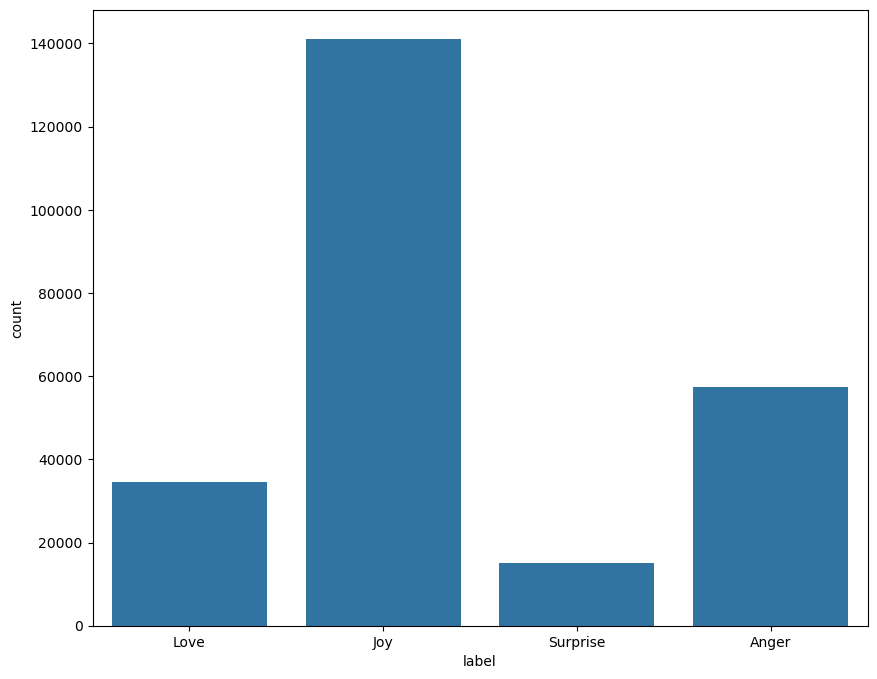

In [41]:
df = pd.read_csv("text_mining/emotions.csv")

display(df.head())
display(df.describe())
plt.figure(figsize=(10,8))
sns.countplot(x="label", data=df)

## (b)

(59888, 2)


,text,label
0,i feel like a jerk because the library student...,Anger
1,i miss all the others as well that feel that i...,Anger
2,i saunter through the airport terminals feelin...,Anger
3,i need to feel dangerous and pretty so here a ...,Anger
4,when,Anger


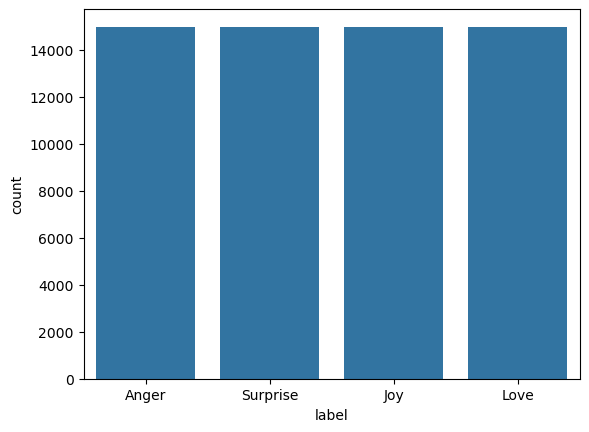

In [42]:
# under sampling by taking the k first entrys from each 

labels = df["label"].unique()
min_label = min([len(df[df["label"]==label]) for label in labels])
#instantiate df for concat
df_balanced = pd.DataFrame([],columns=["text","label"])

for label in labels:
    df_balanced = pd.concat([df[df["label"] == label][:min_label],df_balanced],ignore_index=True)


print(np.shape(df_balanced))
display(df_balanced.head())
# verification
sns.countplot(x="label", data=df_balanced)
df = df_balanced


## (c)

In [43]:
def preprocessing(df: pd.DataFrame)-> list:
    corpus = df["text"]
    doc_list =[]
    for i in range(len(corpus)):
        text = corpus[i]
        tokenized = reg_tokenizer.tokenize(text)
        filtered = [word.lower() for word in tokenized if word.lower() not in stopword_list]
        # print(len(text)-len(filtered))
        lemmatized  = [wordnet_lemmatizer.lemmatize(word) for word in filtered]
        doc = " ".join(lemmatized)
        doc_list.append(doc)
    df_out = pd.DataFrame({"document":doc_list,"label": list(df["label"])})
    return df_out
# calc the difference in length for between un-/preprocessed
def count_tokens(documents) -> int:
    return documents.apply(lambda text: len(text.split(" "))).sum()

processed_df = preprocessing(df)
count_before = count_tokens(df["text"])
count_after = count_tokens(processed_df["document"])
print(f"Number of tokens before processing: {count_before}")
print(f"Number of tokens after processing: {count_after}")
print(f"Difference in tokens after processing: {count_before - count_after}")


Number of tokens before processing: 1187786
Number of tokens after processing: 575839
Difference in tokens after processing: 611947


In [50]:
def split_data(df: pd.DataFrame):
    return train_test_split(df, random_state=12345, train_size=0.8, stratify=df['label'])

train, test = split_data(df)
for data in (train, test):
    for i in range(3):
        print(data.iloc[i]["text"])

my parents came to visit me
ill state that i am angry at myself for feeling so out of control and so hostile
i feel calm complete and whole after i meditate
i feel blessed each day with what i have been given and i understand that these are first world problems i have a roof over my head ample food and freedom and yet
i feel like a loser because all the guys i have liked so far aren t ready for a relationship what do i do
i had a funny feeling when i accepted them


## Bag-of-Words

In [60]:
def train_classifier(df: pd.DataFrame):
    processed_df = preprocessing(df)
    train, test = split_data(processed_df)
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train['document'])
    y_train = train["label"]
    X_test = vectorizer.transform(test['document'])
    y_test = test["label"]
    sgd = SGDClassifier(loss='log_loss', random_state=12345)
    sgd.fit(X_train, y_train)
    #Accuracy on train data:
    train_pred = sgd.predict(X_train)
    acc_train = accuracy_score(y_train, train_pred)
    print(f"Training accuracy: {acc_train:.3f}")
    #Accuracy on test data:
    test_pred = sgd.predict(X_test)
    acc_test = accuracy_score(y_test, test_pred)
    print(f"Test accuracy: {acc_test:.3f}")

train_classifier(df)

Training accuracy: 0.967
Test accuracy: 0.953


## N-Grams

## Word2Vec